In [1]:
import os
import sys

import torch
import torchvision
import torchvision.transforms as tvtf
from torch.utils.data import Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from typing import Tuple

In [2]:
# automatically reloads external files
%load_ext autoreload
%autoreload 2

data_path = '/home/tungnguyendinh/.fastai/data/pascal_2007/'

In [3]:
VOC_CLASSES = (
    'aeroplane', 'bicycle', 'bird', 'boat',
    'bottle', 'bus', 'car', 'cat', 'chair',
    'cow', 'diningtable', 'dog', 'horse',
    'motorbike', 'person', 'pottedplant', 
    'sheep', 'sofa', 'train', 'tvmonitor'
)

def encode_label(labels, classes=VOC_CLASSES):
    '''
    Takes a list of label names as input, encodes them into a binary tensor:
        - Same length as len(VOC_CLASSES)
        - Each element represents the presence (1) or absence (0) of a specific class
        
    '''
    target = torch.zeros(len(classes))
    for l in labels:
        idx = classes.index(l)
        target[idx] = 1 # 1 if label is present 
    
    return target


def decode_target(target, threshold=0.5, classes=VOC_CLASSES):
    '''
    Input: Tensor that represents class confidence score (Sigmoid, not Softmax)
    If score >= threshold, the corresponding class score (classes) is added to label results, 
        which is returned.
    '''
    results = []
    
    for idx, cls_score in enumerate(target):
        if (cls_score >= threshold):
            results.append(classes[idx])
            
    return ' '.join(results)
        
class PascalVOCDataset(Dataset):
    def __init__(self, data_path, csv_file, transform=None, is_test=False, is_valid=False):
        self.data_path = data_path
        self.csv_file = csv_file
        self.transform = transform
        self.is_test = is_test

        # load CSV file containing annotations
        self.annotations = pd.read_csv(os.path.join(data_path, csv_file)) # N * 3

        # filter validation data based on 'is_valid' column
        if is_test:
            pass
        else:
            if is_valid:
                self.annotations = self.annotations[self.annotations['is_valid']==True]
            else:
                self.annotations = self.annotations[self.annotations['is_valid']==False]

    
    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, str]:
        # get image filename and label at specified index:
        img_filename = self.annotations.iloc[index, 0]
        label = self.annotations.iloc[index, 1].split(' ')
        
        # load image
        img_path = os.path.join(self.data_path, 'train', img_filename) if not self.is_test else os.path.join(self.data_path, 'test', img_filename)
        img = Image.open(img_path).convert('RGB')

        # apply transformations
        if self.transform:
            img = self.transform(img)
        
        return img, encode_label(label)
        
        

mean = [.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]


train_transform = tvtf.Compose([
    tvtf.Resize((300, 300)),
    tvtf.RandomCrop((256, 256)),
    tvtf.RandomHorizontalFlip(p=0.2),
    tvtf.ToTensor(),
    tvtf.Normalize(mean=mean, std=std)
])

eval_test_transform = tvtf.Compose([
    tvtf.Resize((300, 300)),
    tvtf.CenterCrop((256, 256)),
    tvtf.RandomHorizontalFlip(p=0.25),
    tvtf.ToTensor(),
    tvtf.Normalize(mean=mean, std=std)
])



# train_ds
ds_train = PascalVOCDataset(data_path, 'train.csv', transform=train_transform, is_test=False, is_valid=False)

# valid_ds
ds_valid = PascalVOCDataset(data_path, 'train.csv', transform=eval_test_transform, is_test=False, is_valid=True)

# test_ds
ds_test = PascalVOCDataset(data_path, 'test.csv', transform=eval_test_transform, is_test=True, is_valid=False)


# DATALOADER
from torch.utils.data import DataLoader

BATCH_SIZE = 68
num_workers = 8

dl_train = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers) 
dl_valid = DataLoader(ds_valid, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)
dl_test = DataLoader(ds_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


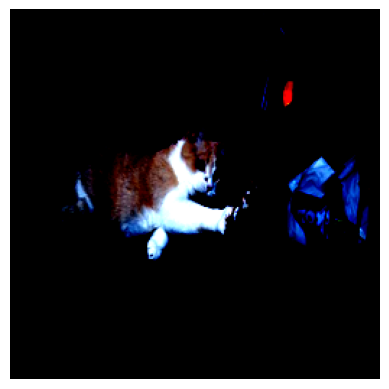

In [4]:
def plot_img(ds, index: int):
    image = ds[index][0].numpy().transpose((1, 2, 0)) # c, h, w -> h, w, c
    plt.imshow(image)
    plt.axis('off')
    plt.show()


plot_img(ds_train, 10)

In [5]:
# # setting device on GPU if available, else CPU
# device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
# print('Using device:', device)
# print()

# #Additional Info when using cuda
# if device.type == 'cuda':
#     print(torch.cuda.get_device_name(0))
#     print('Memory Usage:')
#     print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
#     print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

In [6]:
from classifier_lightning import NNLightning

In [7]:
model = torchvision.models.resnet50(pretrained=True)

for p in model.parameters():
    p.requires_grad = False
    
model.avgpool = torch.nn.AdaptiveAvgPool2d(1)
model.fc = torch.nn.Sequential(torch.nn.Dropout(0,2),
                         torch.nn.Linear(model.fc.in_features, 20))

model = NNLightning(model, threshold=0.5)

/home/hiepphamduc/miniconda3/envs/torch_env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hiepphamduc/miniconda3/envs/torch_env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
import pytorch_lightning as pl

In [9]:
trainer = pl.Trainer(accelerator='gpu', max_epochs=20, precision='16-mixed', log_every_n_steps=1)
trainer.fit(model, dl_train, dl_valid)

/home/hiepphamduc/miniconda3/envs/torch_env/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/hiepphamduc/miniconda3/envs/torch_env/lib/pyth ...
  rank_zero_warn(
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/hiepphamduc/miniconda3/envs/torch_env/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/hiepphamduc/miniconda3/envs/torch_env/lib/pyth ...
  rank_zero_warn(
Init

Sanity Checking: 0it [00:00, ?it/s]

VALIDATION -- avg_loss=tensor(955.8214, device='cuda:0') -- acc=tensor(0.5401, device='cuda:0') -- mod_acc=tensor(0.4532, device='cuda:0')
VALIDATION -- avg_loss=tensor(950.8279, device='cuda:2') -- acc=tensor(0.5581, device='cuda:2') -- mod_acc=tensor(0.4084, device='cuda:2')
VALIDATION -- avg_loss=tensor(947.2518, device='cuda:1') -- acc=tensor(0.5632, device='cuda:1') -- mod_acc=tensor(0.4623, device='cuda:1')
VALIDATION -- avg_loss=tensor(949.4386, device='cuda:3') -- acc=tensor(0.5482, device='cuda:3') -- mod_acc=tensor(0.4406, device='cuda:3')


/home/hiepphamduc/miniconda3/envs/torch_env/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:433: PossibleUserWarning: It is recommended to use `self.log('valid_loss', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
  warning_cache.warn(
/home/hiepphamduc/miniconda3/envs/torch_env/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:433: PossibleUserWarning: It is recommended to use `self.log('valid_acc', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
  warning_cache.warn(
/home/hiepphamduc/miniconda3/envs/torch_env/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:433: PossibleUserWarning: It is recommended to use `self.log('valid_mod_acc', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

VALIDATION -- avg_loss=tensor(657.4727, device='cuda:3') -- acc=tensor(0.8653, device='cuda:3') -- mod_acc=tensor(0.1924, device='cuda:3')VALIDATION -- avg_loss=tensor(650.1040, device='cuda:2') -- acc=tensor(0.8686, device='cuda:2') -- mod_acc=tensor(0.2103, device='cuda:2')VALIDATION -- avg_loss=tensor(672.4233, device='cuda:0') -- acc=tensor(0.8626, device='cuda:0') -- mod_acc=tensor(0.1929, device='cuda:0')VALIDATION -- avg_loss=tensor(659.4344, device='cuda:1') -- acc=tensor(0.8681, device='cuda:1') -- mod_acc=tensor(0.2004, device='cuda:1')



TRAINING -- avg_loss=tensor(754.1982, device='cuda:2', grad_fn=<MeanBackward0>) -- acc=tensor(0.6587, device='cuda:2') -- mod_acc=tensor(0.2931, device='cuda:2')TRAINING -- avg_loss=tensor(753.1982, device='cuda:3', grad_fn=<MeanBackward0>) -- acc=tensor(0.6618, device='cuda:3') -- mod_acc=tensor(0.3103, device='cuda:3')TRAINING -- avg_loss=tensor(758.1574, device='cuda:1', grad_fn=<MeanBackward0>) -- acc=tensor(0.6621, device='cuda:1') -- 

/home/hiepphamduc/miniconda3/envs/torch_env/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:433: PossibleUserWarning: It is recommended to use `self.log('train_loss', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
  warning_cache.warn(
/home/hiepphamduc/miniconda3/envs/torch_env/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:433: PossibleUserWarning: It is recommended to use `self.log('train_acc', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
  warning_cache.warn(
/home/hiepphamduc/miniconda3/envs/torch_env/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:433: PossibleUserWarning: It is recommended to use `self.log('train_mod_acc', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the

Validation: 0it [00:00, ?it/s]

VALIDATION -- avg_loss=tensor(580.4205, device='cuda:0') -- acc=tensor(0.8722, device='cuda:0') -- mod_acc=tensor(0.2968, device='cuda:0')VALIDATION -- avg_loss=tensor(556.4386, device='cuda:3') -- acc=tensor(0.8743, device='cuda:3') -- mod_acc=tensor(0.3020, device='cuda:3')VALIDATION -- avg_loss=tensor(564.3323, device='cuda:2') -- acc=tensor(0.8751, device='cuda:2') -- mod_acc=tensor(0.3128, device='cuda:2')
VALIDATION -- avg_loss=tensor(572.3955, device='cuda:1') -- acc=tensor(0.8745, device='cuda:1') -- mod_acc=tensor(0.2967, device='cuda:1')


TRAINING -- avg_loss=tensor(677.0253, device='cuda:3', grad_fn=<MeanBackward0>) -- acc=tensor(0.7957, device='cuda:3') -- mod_acc=tensor(0.2519, device='cuda:3')TRAINING -- avg_loss=tensor(677.0215, device='cuda:2', grad_fn=<MeanBackward0>) -- acc=tensor(0.7950, device='cuda:2') -- mod_acc=tensor(0.2585, device='cuda:2')
TRAINING -- avg_loss=tensor(682.0363, device='cuda:1', grad_fn=<MeanBackward0>) -- acc=tensor(0.7981, device='cuda:1') --

Validation: 0it [00:00, ?it/s]

VALIDATION -- avg_loss=tensor(455.6790, device='cuda:3') -- acc=tensor(0.8949, device='cuda:3') -- mod_acc=tensor(0.3268, device='cuda:3')VALIDATION -- avg_loss=tensor(462.9998, device='cuda:2') -- acc=tensor(0.8965, device='cuda:2') -- mod_acc=tensor(0.3464, device='cuda:2')
VALIDATION -- avg_loss=tensor(474.3198, device='cuda:0') -- acc=tensor(0.8940, device='cuda:0') -- mod_acc=tensor(0.3339, device='cuda:0')
VALIDATION -- avg_loss=tensor(468.9583, device='cuda:1') -- acc=tensor(0.8949, device='cuda:1') -- mod_acc=tensor(0.3251, device='cuda:1')

TRAINING -- avg_loss=tensor(557.3486, device='cuda:3', grad_fn=<MeanBackward0>) -- acc=tensor(0.8423, device='cuda:3') -- mod_acc=tensor(0.2963, device='cuda:3')
TRAINING -- avg_loss=tensor(562.3192, device='cuda:1', grad_fn=<MeanBackward0>) -- acc=tensor(0.8446, device='cuda:1') -- mod_acc=tensor(0.3102, device='cuda:1')
TRAINING -- avg_loss=tensor(561.7578, device='cuda:2', grad_fn=<MeanBackward0>) -- acc=tensor(0.8419, device='cuda:2') -

Validation: 0it [00:00, ?it/s]

VALIDATION -- avg_loss=tensor(403.0391, device='cuda:0') -- acc=tensor(0.9083, device='cuda:0') -- mod_acc=tensor(0.3644, device='cuda:0')VALIDATION -- avg_loss=tensor(393.8348, device='cuda:2') -- acc=tensor(0.9103, device='cuda:2') -- mod_acc=tensor(0.3787, device='cuda:2')VALIDATION -- avg_loss=tensor(398.8300, device='cuda:1') -- acc=tensor(0.9086, device='cuda:1') -- mod_acc=tensor(0.3571, device='cuda:1')VALIDATION -- avg_loss=tensor(387.7722, device='cuda:3') -- acc=tensor(0.9084, device='cuda:3') -- mod_acc=tensor(0.3539, device='cuda:3')



TRAINING -- avg_loss=tensor(467.4883, device='cuda:2', grad_fn=<MeanBackward0>) -- acc=tensor(0.8698, device='cuda:2') -- mod_acc=tensor(0.3514, device='cuda:2')TRAINING -- avg_loss=tensor(467.4634, device='cuda:3', grad_fn=<MeanBackward0>) -- acc=tensor(0.8690, device='cuda:3') -- mod_acc=tensor(0.3490, device='cuda:3')TRAINING -- avg_loss=tensor(472.6352, device='cuda:1', grad_fn=<MeanBackward0>) -- acc=tensor(0.8705, device='cuda:1') -- 

Validation: 0it [00:00, ?it/s]

VALIDATION -- avg_loss=tensor(348.5866, device='cuda:1') -- acc=tensor(0.9185, device='cuda:1') -- mod_acc=tensor(0.4042, device='cuda:1')VALIDATION -- avg_loss=tensor(352.1544, device='cuda:0') -- acc=tensor(0.9186, device='cuda:0') -- mod_acc=tensor(0.4151, device='cuda:0')VALIDATION -- avg_loss=tensor(338.7676, device='cuda:3') -- acc=tensor(0.9191, device='cuda:3') -- mod_acc=tensor(0.4074, device='cuda:3')VALIDATION -- avg_loss=tensor(344.6226, device='cuda:2') -- acc=tensor(0.9205, device='cuda:2') -- mod_acc=tensor(0.4251, device='cuda:2')



TRAINING -- avg_loss=tensor(408.1294, device='cuda:1', grad_fn=<MeanBackward0>) -- acc=tensor(0.8875, device='cuda:1') -- mod_acc=tensor(0.3966, device='cuda:1')TRAINING -- avg_loss=tensor(404.9378, device='cuda:3', grad_fn=<MeanBackward0>) -- acc=tensor(0.8866, device='cuda:3') -- mod_acc=tensor(0.3938, device='cuda:3')TRAINING -- avg_loss=tensor(405.0384, device='cuda:2', grad_fn=<MeanBackward0>) -- acc=tensor(0.8864, device='cuda:2') -- 

Validation: 0it [00:00, ?it/s]

VALIDATION -- avg_loss=tensor(308.8110, device='cuda:2') -- acc=tensor(0.9277, device='cuda:2') -- mod_acc=tensor(0.4644, device='cuda:2')VALIDATION -- avg_loss=tensor(315.2013, device='cuda:0') -- acc=tensor(0.9263, device='cuda:0') -- mod_acc=tensor(0.4575, device='cuda:0')

TRAINING -- avg_loss=tensor(358.7444, device='cuda:2', grad_fn=<MeanBackward0>) -- acc=tensor(0.8987, device='cuda:2') -- mod_acc=tensor(0.4246, device='cuda:2')
VALIDATION -- avg_loss=tensor(312.5798, device='cuda:1') -- acc=tensor(0.9257, device='cuda:1') -- mod_acc=tensor(0.4423, device='cuda:1')VALIDATION -- avg_loss=tensor(303.3945, device='cuda:3') -- acc=tensor(0.9268, device='cuda:3') -- mod_acc=tensor(0.4526, device='cuda:3')

TRAINING -- avg_loss=tensor(356.7201, device='cuda:0', grad_fn=<MeanBackward0>) -- acc=tensor(0.9001, device='cuda:0') -- mod_acc=tensor(0.4395, device='cuda:0')
TRAINING -- avg_loss=tensor(362.1752, device='cuda:1', grad_fn=<MeanBackward0>) -- acc=tensor(0.9001, device='cuda:1') -

Validation: 0it [00:00, ?it/s]

VALIDATION -- avg_loss=tensor(276.9814, device='cuda:3') -- acc=tensor(0.9327, device='cuda:3') -- mod_acc=tensor(0.4861, device='cuda:3')VALIDATION -- avg_loss=tensor(282.3203, device='cuda:2') -- acc=tensor(0.9332, device='cuda:2') -- mod_acc=tensor(0.4943, device='cuda:2')VALIDATION -- avg_loss=tensor(285.4591, device='cuda:1') -- acc=tensor(0.9316, device='cuda:1') -- mod_acc=tensor(0.4758, device='cuda:1')


VALIDATION -- avg_loss=tensor(287.4995, device='cuda:0') -- acc=tensor(0.9322, device='cuda:0') -- mod_acc=tensor(0.4896, device='cuda:0')
TRAINING -- avg_loss=tensor(325.4655, device='cuda:3', grad_fn=<MeanBackward0>) -- acc=tensor(0.9087, device='cuda:3') -- mod_acc=tensor(0.4652, device='cuda:3')TRAINING -- avg_loss=tensor(327.1594, device='cuda:1', grad_fn=<MeanBackward0>) -- acc=tensor(0.9092, device='cuda:1') -- mod_acc=tensor(0.4685, device='cuda:1')
TRAINING -- avg_loss=tensor(324.3235, device='cuda:2', grad_fn=<MeanBackward0>) -- acc=tensor(0.9081, device='cuda:2') --

Validation: 0it [00:00, ?it/s]

VALIDATION -- avg_loss=tensor(256.3522, device='cuda:3') -- acc=tensor(0.9373, device='cuda:3') -- mod_acc=tensor(0.5131, device='cuda:3')VALIDATION -- avg_loss=tensor(261.5343, device='cuda:2') -- acc=tensor(0.9376, device='cuda:2') -- mod_acc=tensor(0.5188, device='cuda:2')VALIDATION -- avg_loss=tensor(265.9372, device='cuda:0') -- acc=tensor(0.9368, device='cuda:0') -- mod_acc=tensor(0.5158, device='cuda:0')

VALIDATION -- avg_loss=tensor(264.3469, device='cuda:1') -- acc=tensor(0.9360, device='cuda:1') -- mod_acc=tensor(0.5009, device='cuda:1')

TRAINING -- avg_loss=tensor(299.1112, device='cuda:3', grad_fn=<MeanBackward0>) -- acc=tensor(0.9159, device='cuda:3') -- mod_acc=tensor(0.4908, device='cuda:3')TRAINING -- avg_loss=tensor(297.6152, device='cuda:2', grad_fn=<MeanBackward0>) -- acc=tensor(0.9156, device='cuda:2') -- mod_acc=tensor(0.4819, device='cuda:2')

TRAINING -- avg_loss=tensor(300.5041, device='cuda:1', grad_fn=<MeanBackward0>) -- acc=tensor(0.9163, device='cuda:1') -

Validation: 0it [00:00, ?it/s]

VALIDATION -- avg_loss=tensor(249.3703, device='cuda:0') -- acc=tensor(0.9403, device='cuda:0') -- mod_acc=tensor(0.5415, device='cuda:0')
VALIDATION -- avg_loss=tensor(245.4479, device='cuda:2') -- acc=tensor(0.9411, device='cuda:2') -- mod_acc=tensor(0.5452, device='cuda:2')VALIDATION -- avg_loss=tensor(248.2952, device='cuda:1') -- acc=tensor(0.9394, device='cuda:1') -- mod_acc=tensor(0.5261, device='cuda:1')VALIDATION -- avg_loss=tensor(240.4826, device='cuda:3') -- acc=tensor(0.9408, device='cuda:3') -- mod_acc=tensor(0.5400, device='cuda:3')


TRAINING -- avg_loss=tensor(279.0172, device='cuda:1', grad_fn=<MeanBackward0>) -- acc=tensor(0.9222, device='cuda:1') -- mod_acc=tensor(0.5136, device='cuda:1')
TRAINING -- avg_loss=tensor(277.2939, device='cuda:0', grad_fn=<MeanBackward0>) -- acc=tensor(0.9215, device='cuda:0') -- mod_acc=tensor(0.5095, device='cuda:0')
TRAINING -- avg_loss=tensor(277.4800, device='cuda:2', grad_fn=<MeanBackward0>) -- acc=tensor(0.9211, device='cuda:2') -

Validation: 0it [00:00, ?it/s]

VALIDATION -- avg_loss=tensor(227.1109, device='cuda:3') -- acc=tensor(0.9437, device='cuda:3') -- mod_acc=tensor(0.5594, device='cuda:3')VALIDATION -- avg_loss=tensor(235.4850, device='cuda:0') -- acc=tensor(0.9434, device='cuda:0') -- mod_acc=tensor(0.5612, device='cuda:0')
VALIDATION -- avg_loss=tensor(234.9514, device='cuda:1') -- acc=tensor(0.9422, device='cuda:1') -- mod_acc=tensor(0.5454, device='cuda:1')

VALIDATION -- avg_loss=tensor(231.9137, device='cuda:2') -- acc=tensor(0.9440, device='cuda:2') -- mod_acc=tensor(0.5631, device='cuda:2')
TRAINING -- avg_loss=tensor(260.7961, device='cuda:3', grad_fn=<MeanBackward0>) -- acc=tensor(0.9265, device='cuda:3') -- mod_acc=tensor(0.5311, device='cuda:3')
TRAINING -- avg_loss=tensor(261.5480, device='cuda:1', grad_fn=<MeanBackward0>) -- acc=tensor(0.9267, device='cuda:1') -- mod_acc=tensor(0.5317, device='cuda:1')
TRAINING -- avg_loss=tensor(261.1140, device='cuda:2', grad_fn=<MeanBackward0>) -- acc=tensor(0.9256, device='cuda:2') -

Validation: 0it [00:00, ?it/s]

VALIDATION -- avg_loss=tensor(224.0638, device='cuda:0') -- acc=tensor(0.9458, device='cuda:0') -- mod_acc=tensor(0.5733, device='cuda:0')VALIDATION -- avg_loss=tensor(216.0474, device='cuda:3') -- acc=tensor(0.9462, device='cuda:3') -- mod_acc=tensor(0.5729, device='cuda:3')

TRAINING -- avg_loss=tensor(245.8819, device='cuda:3', grad_fn=<MeanBackward0>) -- acc=tensor(0.9308, device='cuda:3') -- mod_acc=tensor(0.5499, device='cuda:3')
VALIDATION -- avg_loss=tensor(223.8477, device='cuda:1') -- acc=tensor(0.9445, device='cuda:1') -- mod_acc=tensor(0.5585, device='cuda:1')
TRAINING -- avg_loss=tensor(246.3283, device='cuda:0', grad_fn=<MeanBackward0>) -- acc=tensor(0.9301, device='cuda:0') -- mod_acc=tensor(0.5451, device='cuda:0')
TRAINING -- avg_loss=tensor(247.6998, device='cuda:1', grad_fn=<MeanBackward0>) -- acc=tensor(0.9306, device='cuda:1') -- mod_acc=tensor(0.5468, device='cuda:1')
VALIDATION -- avg_loss=tensor(221.1476, device='cuda:2') -- acc=tensor(0.9462, device='cuda:2') -

Validation: 0it [00:00, ?it/s]

VALIDATION -- avg_loss=tensor(214.3098, device='cuda:0') -- acc=tensor(0.9479, device='cuda:0') -- mod_acc=tensor(0.5879, device='cuda:0')VALIDATION -- avg_loss=tensor(214.4193, device='cuda:1') -- acc=tensor(0.9466, device='cuda:1') -- mod_acc=tensor(0.5728, device='cuda:1')VALIDATION -- avg_loss=tensor(206.8145, device='cuda:3') -- acc=tensor(0.9483, device='cuda:3') -- mod_acc=tensor(0.5881, device='cuda:3')VALIDATION -- avg_loss=tensor(211.8084, device='cuda:2') -- acc=tensor(0.9482, device='cuda:2') -- mod_acc=tensor(0.5883, device='cuda:2')



TRAINING -- avg_loss=tensor(235.7490, device='cuda:1', grad_fn=<MeanBackward0>) -- acc=tensor(0.9338, device='cuda:1') -- mod_acc=tensor(0.5597, device='cuda:1')TRAINING -- avg_loss=tensor(233.5652, device='cuda:3', grad_fn=<MeanBackward0>) -- acc=tensor(0.9342, device='cuda:3') -- mod_acc=tensor(0.5628, device='cuda:3')TRAINING -- avg_loss=tensor(235.8443, device='cuda:2', grad_fn=<MeanBackward0>) -- acc=tensor(0.9324, device='cuda:2') -- 

Validation: 0it [00:00, ?it/s]

VALIDATION -- avg_loss=tensor(205.8640, device='cuda:0') -- acc=tensor(0.9497, device='cuda:0') -- mod_acc=tensor(0.5998, device='cuda:0')VALIDATION -- avg_loss=tensor(203.6902, device='cuda:2') -- acc=tensor(0.9500, device='cuda:2') -- mod_acc=tensor(0.5999, device='cuda:2')VALIDATION -- avg_loss=tensor(206.2659, device='cuda:1') -- acc=tensor(0.9483, device='cuda:1') -- mod_acc=tensor(0.5846, device='cuda:1')VALIDATION -- avg_loss=tensor(198.6879, device='cuda:3') -- acc=tensor(0.9502, device='cuda:3') -- mod_acc=tensor(0.6003, device='cuda:3')



TRAINING -- avg_loss=tensor(225.5344, device='cuda:2', grad_fn=<MeanBackward0>) -- acc=tensor(0.9353, device='cuda:2') -- mod_acc=tensor(0.5596, device='cuda:2')TRAINING -- avg_loss=tensor(225.0595, device='cuda:1', grad_fn=<MeanBackward0>) -- acc=tensor(0.9368, device='cuda:1') -- mod_acc=tensor(0.5727, device='cuda:1')TRAINING -- avg_loss=tensor(223.0620, device='cuda:3', grad_fn=<MeanBackward0>) -- acc=tensor(0.9371, device='cuda:3') -- 

Validation: 0it [00:00, ?it/s]

VALIDATION -- avg_loss=tensor(198.6698, device='cuda:0') -- acc=tensor(0.9514, device='cuda:0') -- mod_acc=tensor(0.6107, device='cuda:0')VALIDATION -- avg_loss=tensor(191.8308, device='cuda:3') -- acc=tensor(0.9517, device='cuda:3') -- mod_acc=tensor(0.6113, device='cuda:3')VALIDATION -- avg_loss=tensor(199.4717, device='cuda:1') -- acc=tensor(0.9498, device='cuda:1') -- mod_acc=tensor(0.5950, device='cuda:1')


TRAINING -- avg_loss=tensor(214.6316, device='cuda:3', grad_fn=<MeanBackward0>) -- acc=tensor(0.9394, device='cuda:3') -- mod_acc=tensor(0.5841, device='cuda:3')
TRAINING -- avg_loss=tensor(215.4075, device='cuda:1', grad_fn=<MeanBackward0>) -- acc=tensor(0.9396, device='cuda:1') -- mod_acc=tensor(0.5861, device='cuda:1')
TRAINING -- avg_loss=tensor(215.0872, device='cuda:0', grad_fn=<MeanBackward0>) -- acc=tensor(0.9390, device='cuda:0') -- mod_acc=tensor(0.5827, device='cuda:0')
VALIDATION -- avg_loss=tensor(196.8111, device='cuda:2') -- acc=tensor(0.9514, device='cuda:2') -

Validation: 0it [00:00, ?it/s]

VALIDATION -- avg_loss=tensor(192.6153, device='cuda:0') -- acc=tensor(0.9526, device='cuda:0') -- mod_acc=tensor(0.6204, device='cuda:0')VALIDATION -- avg_loss=tensor(190.8351, device='cuda:2') -- acc=tensor(0.9527, device='cuda:2') -- mod_acc=tensor(0.6200, device='cuda:2')

VALIDATION -- avg_loss=tensor(193.5977, device='cuda:1') -- acc=tensor(0.9509, device='cuda:1') -- mod_acc=tensor(0.6050, device='cuda:1')
VALIDATION -- avg_loss=tensor(186.1203, device='cuda:3') -- acc=tensor(0.9528, device='cuda:3') -- mod_acc=tensor(0.6211, device='cuda:3')
TRAINING -- avg_loss=tensor(208.7853, device='cuda:2', grad_fn=<MeanBackward0>) -- acc=tensor(0.9400, device='cuda:2') -- mod_acc=tensor(0.5808, device='cuda:2')
TRAINING -- avg_loss=tensor(207.4461, device='cuda:1', grad_fn=<MeanBackward0>) -- acc=tensor(0.9418, device='cuda:1') -- mod_acc=tensor(0.5951, device='cuda:1')
TRAINING -- avg_loss=tensor(206.9993, device='cuda:0', grad_fn=<MeanBackward0>) -- acc=tensor(0.9413, device='cuda:0') -

Validation: 0it [00:00, ?it/s]

VALIDATION -- avg_loss=tensor(186.9862, device='cuda:0') -- acc=tensor(0.9538, device='cuda:0') -- mod_acc=tensor(0.6282, device='cuda:0')VALIDATION -- avg_loss=tensor(180.6935, device='cuda:3') -- acc=tensor(0.9540, device='cuda:3') -- mod_acc=tensor(0.6284, device='cuda:3')VALIDATION -- avg_loss=tensor(188.0873, device='cuda:1') -- acc=tensor(0.9521, device='cuda:1') -- mod_acc=tensor(0.6130, device='cuda:1')VALIDATION -- avg_loss=tensor(185.3795, device='cuda:2') -- acc=tensor(0.9538, device='cuda:2') -- mod_acc=tensor(0.6269, device='cuda:2')



TRAINING -- avg_loss=tensor(201.0299, device='cuda:3', grad_fn=<MeanBackward0>) -- acc=tensor(0.9430, device='cuda:3') -- mod_acc=tensor(0.5982, device='cuda:3')
TRAINING -- avg_loss=tensor(201.7511, device='cuda:2', grad_fn=<MeanBackward0>) -- acc=tensor(0.9418, device='cuda:2') -- mod_acc=tensor(0.5888, device='cuda:2')TRAINING -- avg_loss=tensor(200.5150, device='cuda:1', grad_fn=<MeanBackward0>) -- acc=tensor(0.9436, device='cuda:1') --

Validation: 0it [00:00, ?it/s]

VALIDATION -- avg_loss=tensor(180.6061, device='cuda:2') -- acc=tensor(0.9549, device='cuda:2') -- mod_acc=tensor(0.6335, device='cuda:2')VALIDATION -- avg_loss=tensor(181.9701, device='cuda:0') -- acc=tensor(0.9549, device='cuda:0') -- mod_acc=tensor(0.6351, device='cuda:0')VALIDATION -- avg_loss=tensor(175.9946, device='cuda:3') -- acc=tensor(0.9551, device='cuda:3') -- mod_acc=tensor(0.6352, device='cuda:3')


VALIDATION -- avg_loss=tensor(183.2355, device='cuda:1') -- acc=tensor(0.9532, device='cuda:1') -- mod_acc=tensor(0.6198, device='cuda:1')
TRAINING -- avg_loss=tensor(195.5577, device='cuda:2', grad_fn=<MeanBackward0>) -- acc=tensor(0.9434, device='cuda:2') -- mod_acc=tensor(0.5958, device='cuda:2')TRAINING -- avg_loss=tensor(194.9471, device='cuda:3', grad_fn=<MeanBackward0>) -- acc=tensor(0.9448, device='cuda:3') -- mod_acc=tensor(0.6046, device='cuda:3')
TRAINING -- avg_loss=tensor(194.2396, device='cuda:1', grad_fn=<MeanBackward0>) -- acc=tensor(0.9454, device='cuda:1') --

Validation: 0it [00:00, ?it/s]

VALIDATION -- avg_loss=tensor(177.4847, device='cuda:0') -- acc=tensor(0.9559, device='cuda:0') -- mod_acc=tensor(0.6411, device='cuda:0')VALIDATION -- avg_loss=tensor(178.9194, device='cuda:1') -- acc=tensor(0.9542, device='cuda:1') -- mod_acc=tensor(0.6261, device='cuda:1')VALIDATION -- avg_loss=tensor(176.3086, device='cuda:2') -- acc=tensor(0.9558, device='cuda:2') -- mod_acc=tensor(0.6391, device='cuda:2')
VALIDATION -- avg_loss=tensor(171.7061, device='cuda:3') -- acc=tensor(0.9562, device='cuda:3') -- mod_acc=tensor(0.6418, device='cuda:3')


TRAINING -- avg_loss=tensor(189.7152, device='cuda:3', grad_fn=<MeanBackward0>) -- acc=tensor(0.9462, device='cuda:3') -- mod_acc=tensor(0.6094, device='cuda:3')TRAINING -- avg_loss=tensor(189.9349, device='cuda:2', grad_fn=<MeanBackward0>) -- acc=tensor(0.9451, device='cuda:2') -- mod_acc=tensor(0.6035, device='cuda:2')TRAINING -- avg_loss=tensor(188.5702, device='cuda:1', grad_fn=<MeanBackward0>) -- acc=tensor(0.9469, device='cuda:1') -- 

Validation: 0it [00:00, ?it/s]

VALIDATION -- avg_loss=tensor(173.6431, device='cuda:0') -- acc=tensor(0.9567, device='cuda:0') -- mod_acc=tensor(0.6449, device='cuda:0')VALIDATION -- avg_loss=tensor(172.7589, device='cuda:2') -- acc=tensor(0.9565, device='cuda:2') -- mod_acc=tensor(0.6421, device='cuda:2')VALIDATION -- avg_loss=tensor(168.0207, device='cuda:3') -- acc=tensor(0.9571, device='cuda:3') -- mod_acc=tensor(0.6467, device='cuda:3')VALIDATION -- avg_loss=tensor(175.1850, device='cuda:1') -- acc=tensor(0.9550, device='cuda:1') -- mod_acc=tensor(0.6298, device='cuda:1')



TRAINING -- avg_loss=tensor(185.0090, device='cuda:2', grad_fn=<MeanBackward0>) -- acc=tensor(0.9465, device='cuda:2') -- mod_acc=tensor(0.6102, device='cuda:2')
TRAINING -- avg_loss=tensor(183.3237, device='cuda:1', grad_fn=<MeanBackward0>) -- acc=tensor(0.9484, device='cuda:1') -- mod_acc=tensor(0.6250, device='cuda:1')
TRAINING -- avg_loss=tensor(184.7440, device='cuda:3', grad_fn=<MeanBackward0>) -- acc=tensor(0.9477, device='cuda:3') -

Validation: 0it [00:00, ?it/s]

VALIDATION -- avg_loss=tensor(171.6060, device='cuda:1') -- acc=tensor(0.9558, device='cuda:1') -- mod_acc=tensor(0.6351, device='cuda:1')VALIDATION -- avg_loss=tensor(164.5011, device='cuda:3') -- acc=tensor(0.9579, device='cuda:3') -- mod_acc=tensor(0.6520, device='cuda:3')VALIDATION -- avg_loss=tensor(169.2309, device='cuda:2') -- acc=tensor(0.9573, device='cuda:2') -- mod_acc=tensor(0.6467, device='cuda:2')


VALIDATION -- avg_loss=tensor(170.0227, device='cuda:0') -- acc=tensor(0.9575, device='cuda:0') -- mod_acc=tensor(0.6499, device='cuda:0')
TRAINING -- avg_loss=tensor(178.6436, device='cuda:1', grad_fn=<MeanBackward0>) -- acc=tensor(0.9497, device='cuda:1') -- mod_acc=tensor(0.6315, device='cuda:1')TRAINING -- avg_loss=tensor(180.2392, device='cuda:3', grad_fn=<MeanBackward0>) -- acc=tensor(0.9489, device='cuda:3') -- mod_acc=tensor(0.6219, device='cuda:3')

TRAINING -- avg_loss=tensor(180.6771, device='cuda:2', grad_fn=<MeanBackward0>) -- acc=tensor(0.9477, device='cuda:2') -

`Trainer.fit` stopped: `max_epochs=20` reached.


In [22]:
predictions = trainer.predict(model, dl_test)

/home/hiepphamduc/miniconda3/envs/torch_env/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/hiepphamduc/miniconda3/envs/torch_env/lib/pyth ...
  rank_zero_warn(
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/4
/home/hiepphamduc/miniconda3/envs/torch_env/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/hiepphamduc/miniconda3/envs/torch_env/lib/pyth ...
  rank_zero_warn(
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/4
/home/hiepphamduc/miniconda3/envs/torch_env/lib/python3.11/site-packages/lightning_fabric/pl

Predicting: 0it [00:00, ?it/s]

In [ ]:
# eval_loss, correct = 0, 0
# i = 0
# low_acc_lst = None
# with torch.no_grad():
#     for X, y in dl_test:
#         #X, y = X.to(device), y.to(device)
#         out = model(X)
#         out = torch.nn.Sigmoid()(out)
#         if i == 0:
#             low_acc_lst = out
#         else:
#             low_acc_lst = torch.cat((low_acc_lst, out))    
#         i += 1
#         if i == 50:
#             break


In [28]:
# inv_normalize = tvtf.Normalize(
#     mean= [-m for m in mean],
#     std= [1/s for s in std]
# )

In [29]:
# sample_idx = 10

# figure = plt.figure(figsize=(10, 10))
# cols, rows = 3, 3
# for i in range(1, cols * rows + 1):
#     sample_idx = torch.randint(len(predictions), size=(1,)).item()
#     img, label = ds_test[sample_idx]
#     img, label = img.to("cpu"), label.to("cpu")
#     img = inv_normalize(img)
#     figure.add_subplot(rows, cols, i)
#     true_label = decode_target(label)
#     pred_label = decode_target(predictions[sample_idx])
#     title = f"True label: {true_label}\nPred label: {pred_label}"
#     plt.title(title)
#     plt.axis("off")
#     plt.imshow(img.squeeze().permute(1, 2, 0), cmap="gray")
# plt.show()